# Image block segmentation

There are subcomponents in each print image, and the first task is to pick them out based on height.

## I) Image importation

Let's assume we want to break up the image below:

In [1]:
!pip install Pillow
!pip install numpy
!pip install pythonRLSA
!pip install opencv-python-headless

In [2]:
from PIL import Image # Pillow package
import cv2 # Open CV package
import numpy as np # Numpy package
import math
from pythonRLSA import rlsa

ModuleNotFoundError: No module named 'pythonRLSA'

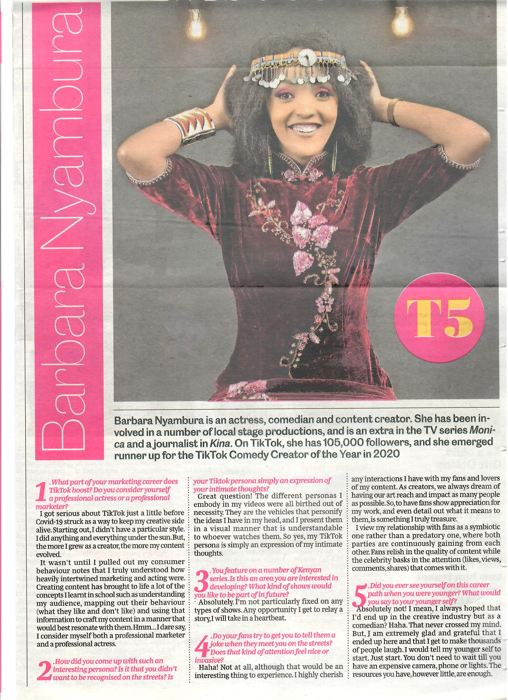

In [3]:
try:
    sample_image_path = "./kip-images/17_12_2021_Nation_MyNetWork_pg9.jpg"
    img = Image.open(sample_image_path)
except:
    sample_image_path = "/home/jovyan/book/kenyans-in-print/kip-images/17_12_2021_Nation_MyNetWork_pg9.jpg"
    img = Image.open(sample_image_path)


width, height = img.size
display(img.resize(
    (int(width*0.2),int(height*0.2))
    ))

How can we "read" the article above in a programmatic way?

We would need to isolate various elements in the photo like the title and captions, which are larger than the body text.

Luckily, with AI and OCR technologies, we can do just that.

<br>

## II) Use of the height heuristics approach

Distinguishing between content elements vertically has 3 key steps:

* Convert image to grayscale image, then binary image
* Find contours based on binary grayscale
* Use height heuristics to get indivisual regions in the image taller than others.

### Round One

👇🏾 Reading the image

In [ ]:
image = cv2.imread(sample_image_path)

👇🏾 Converting the image to grayscale

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

👇🏾 Converting the image to binary

In [ ]:
(thresh, binary) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY |
                                 cv2.THRESH_OTSU)

im_pil = Image.fromarray(binary)

# CODE CHECK CELL
display(im_pil.resize(
    (int(width*0.2),int(height*0.2))
    ))

## References

https://stackoverflow.com/questions/10262600/how-to-detect-region-of-large-of-white-pixels-using-opencv#10266717

https://www.geeksforgeeks.org/python-pil-image-crop-method/

https://machinelearningknowledge.ai/how-to-scale-and-resize-image-in-python-with-opencv-cv2-resize/

https://stackoverflow.com/questions/43232813/convert-opencv-image-format-to-pil-image-format#43234001

https://www.freedomvc.com/index.php/2021/06/26/contours-and-bounding-boxes/

https://stackoverflow.com/questions/33299412/article-extraction-from-newspaper-image-in-python-and-opencv

https://medium.com/@vasista/extract-title-from-the-image-documents-in-python-application-of-rlsa-58f91237901f